# Creating Tensors

In [4]:
import torch
import numpy as np

In [2]:
list_tensor = torch.tensor([1, 2, 3])

In [3]:
list_tensor

tensor([1, 2, 3])

In [8]:
numpy_tensor = torch.tensor(np.zeros((4, 4), dtype=np.int32))
numpy_tensor

tensor([[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]], dtype=torch.int32)

In [17]:
second_np = np.ones((3, 3)) * 0.5

In [18]:
np_tensor = torch.from_numpy(second_np)

In [19]:
np_tensor * list_tensor

tensor([[0.5000, 1.0000, 1.5000],
        [0.5000, 1.0000, 1.5000],
        [0.5000, 1.0000, 1.5000]], dtype=torch.float64)

# Computational graphs

In [22]:
import torch

x = torch.tensor(2.0, requires_grad=True)  # Mark for gradient tracking
y = (x + 2) * x * 3
y.backward()  # Triggers backpropagation

print(x.grad)  # Access the computed gradient
print(y)

tensor(18.)
tensor(24., grad_fn=<MulBackward0>)


## Visualize Graph 

In [27]:
import torch
from torchviz import make_dot
import matplotlib.pyplot as plt
import cv2 as cv

x = torch.tensor([2.0], requires_grad=True)
y = torch.tensor([5.0], requires_grad=True)

a = x * x + 3 * y
b = a.exp()
c = 2 * b  # Final output

make_dot(c).render("attached", format="png")

'attached.png'

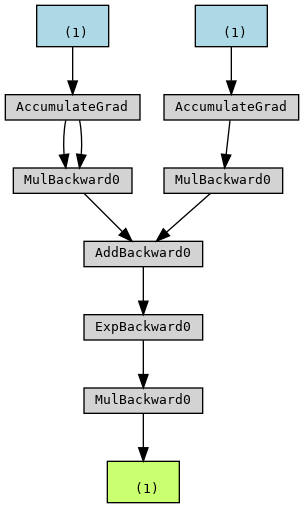

In [28]:
from PIL import Image
from IPython.display import display

img = Image.open("attached.png")
display(img)

## Datasets & DataLoaders

* Decoupling training code from processing data samples is good code styling and can help with maintaining large code bases.
* Two primitives to use: torch.utils.data.DataLoader and torch.utils.data.Dataset

Datasets are used to store the samples and their labels while a Dataloader wraps an iterable arouind a Dataset to be accessed during training

In [2]:
# Loading FashionMNIST DataSet
import torch
from torch.utils.data import Dataset
# Note that torchvision has the pre-availble datasets
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [3]:
training_data = datasets.FashionMNIST(
    root="Data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="Data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [4]:
class_map = {index:obj for index, obj in enumerate(training_data.classes)}
class_map

{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}

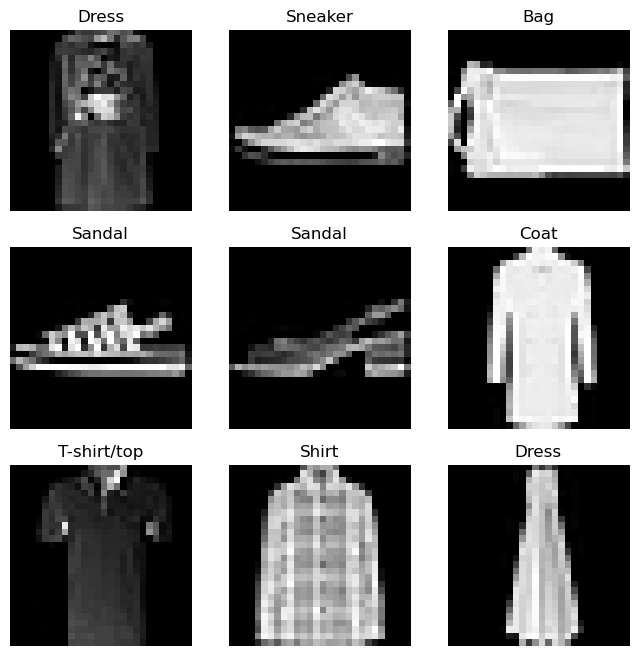

In [5]:
# Plotting 9 random samples from the dataset
figure = plt.figure(figsize=(8,8))
cols, rows = 3, 3
## Starting at 1 because add_subplot is 1-based
for i in range(1, cols * rows + 1):
    random_sample_index = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[random_sample_index]
    figure.add_subplot(rows, cols, i)
    plt.title(class_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

# Creating a Custom Dataset for your files
## Dataset

* __init__ will initialize all transformation and file/label paths needed for this dataset. Also any other data manipulation here too I believe
* __len__ will return total amount of dataset
* __getitem__ will fetch the image into a tensor and the corresponding label and transform it if necessary. Then return both the image and label for that index

In [9]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, index):
        # labels first column has the file names
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[index, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[index, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

## Dataloader
* Dataset gives the sample and label one at a time. Data loader will compile that into batches. It can also provide shuffling as well which is good for training. 

In [11]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Now the datasets has been loaded into each corresponding dataloaders. Just by iterating through the data loader we will then get batches of our data that are shuffled. Below is iterating through the dataloader for one step and displaying the first data sample with its corresponding label

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


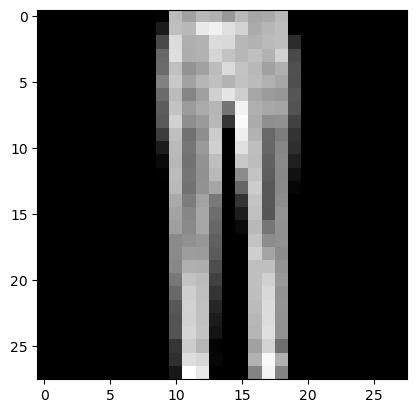

Label: 1


In [12]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

# Transforms

Transforms can manipulate the data to make it usable for training. Or expand the use of the training data.

Transform parameter in Dataset will allow us to transform the feature and target_transform will transform the corresponding label



In [16]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

ds = datasets.FashionMNIST(
    root="Data",
    train=True,
    download=True,
    transform=ToTensor(),
    # Lambda transforms apply any user-defined lambda function.
    # Here, we define a function to turn the integer into a one-hot encoded tensor.
    # It first creates a zero tensor of size 10 (the number 
    # of labels in our dataset) and calls scatter_ 
    # which assigns a value=1 on the index as given by the label y.
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

# Build the Neural Network

torch.nn provides all the building blocks for building neural networks

Every module in pytorch in torch.nn subclasses the nn.Module

In [17]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [19]:
# Check what device to use for hardware acceleration
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [22]:
# Defining the neural network requires us to subclass the nn.Module
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )
        
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [23]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


To use the model, we pass it the input data. This executes the model’s forward, along with some background operations. __Do not call model.forward() directly!__

In [24]:
X = torch.rand(1, 28, 28, device=device)
logits = model(X)
logits

tensor([[ 0.1121, -0.0356,  0.0510, -0.0473, -0.0008,  0.0780, -0.0320, -0.0309,
         -0.0538,  0.0144]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [29]:
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

Predicted class: tensor([0], device='cuda:0')


In [30]:
# This would be an example mini batch of 3
input_image = torch.rand(3,28,28)
print(input_image.size())

torch.Size([3, 28, 28])


__nn.Flatten__ converts the 2D 28x28 image in a single contiguous array of 784 pixels. Mini batch dimensionality is retained.

In [31]:
flatten = nn.Flatten()
flat_image = flatten(input_image)
print(flat_image.size())

torch.Size([3, 784])


__nn.Linear__ applies a linear transformation on the input and weights and biases.

In [32]:
layer1 = nn.Linear(in_features=28*28, out_features=20)
hidden1 = layer1(flat_image)
print(hidden1.size())

torch.Size([3, 20])


Next step is to introduce non-linear activations to create complex mappings between the model's input and output. These are processed after the linear transformation occurs. The non-linear activations are applied to the outputs of the linear transformation.

In [36]:
print(f"Before ReLU: {hidden1}\n\n")
hidden1 = nn.ReLU()(hidden1)
print(f"After ReLU: {hidden1}")
print(hidden1.size())

Before ReLU: tensor([[0.0000, 0.0000, 0.2318, 0.0000, 0.0000, 0.1742, 0.0000, 0.0000, 0.1570,
         0.0000, 0.0000, 0.1101, 0.0000, 0.3635, 0.2796, 0.0000, 0.0000, 0.0000,
         0.0515, 0.0761],
        [0.0000, 0.0000, 0.5283, 0.0000, 0.0000, 0.3958, 0.0000, 0.0000, 0.2151,
         0.0000, 0.0000, 0.1361, 0.0000, 0.0000, 0.3166, 0.0000, 0.0000, 0.2914,
         0.0000, 0.1036],
        [0.0000, 0.0000, 0.0643, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.4834,
         0.0000, 0.0000, 0.0000, 0.0000, 0.5417, 0.0000, 0.0000, 0.0500, 0.3753,
         0.1354, 0.4312]], grad_fn=<ReluBackward0>)


After ReLU: tensor([[0.0000, 0.0000, 0.2318, 0.0000, 0.0000, 0.1742, 0.0000, 0.0000, 0.1570,
         0.0000, 0.0000, 0.1101, 0.0000, 0.3635, 0.2796, 0.0000, 0.0000, 0.0000,
         0.0515, 0.0761],
        [0.0000, 0.0000, 0.5283, 0.0000, 0.0000, 0.3958, 0.0000, 0.0000, 0.2151,
         0.0000, 0.0000, 0.1361, 0.0000, 0.0000, 0.3166, 0.0000, 0.0000, 0.2914,
         0.0000, 0.1036],
       

__nn.Sequential__ Creates and ordered set of the modules and are sequential in processing.

In [37]:
seq_modules = nn.Sequential(
    flatten,
    layer1,
    nn.ReLU(),
    nn.Linear(20, 10)
)
input_image = torch.rand(3,28,28)
logits = seq_modules(input_image)

The last layer is the output layer that in the classification case will give the raw value of the likelihood of it being this class. These values are passed to the __nn.Softmax__ module to get the predicted probabilities of the class. The values are scaled to [0, 1] Dim parameter indicates the dimension along which the values must sum to 1.

In [45]:
softmax = nn.Softmax(dim=1)
pred_probab = softmax(logits)
pred_probab.sum(1)

tensor([1.0000, 1.0000, 1.0000], grad_fn=<SumBackward1>)

You can get the associated weights and biases from the model that subclasses __nn.Module__. You can use __parameters()__ or __named_parameters()__ to get these.

In [46]:
print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Model structure: NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Layer: linear_relu_stack.0.weight | Size: torch.Size([512, 784]) | Values : tensor([[-0.0090, -0.0335,  0.0164,  ...,  0.0130, -0.0178,  0.0297],
        [-0.0239,  0.0132, -0.0201,  ..., -0.0107,  0.0290,  0.0199]],
       device='cuda:0', grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.0.bias | Size: torch.Size([512]) | Values : tensor([-0.0252,  0.0103], device='cuda:0', grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.weight | Size: torch.Size([512, 512]) | Values : tensor([[ 0.0390,  0.0421,  0.0331,  ..., -0.0279,  0.0314,  0.0221],
        [-0.0371, -0.0037, -0.0198,  ..., -0.0312,  0.0088,  0.0028]],
       device='cuda:0', grad_fn=<Sl

# Training & Autograd

Training most neural networks __back propagation__ is used. This adjust the gradient of the loss function to attempt to decent to a global minimum.

To compute the gradients, pytorch has a build-in differentiation engine call __torch.autograd__ 

In [59]:
# simple 1 layer NN to show autograd

import torch

x = torch.ones(5)  # input tensor
y = torch.zeros(3)  # expected output
w = torch.randn(5, 3, requires_grad=True)
b = torch.randn(3, requires_grad=True)
z = torch.matmul(x, w)+b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)

Setting requires_grad=True gives us the ability to compute the gradients of loss function.
The object grad_fn (Function) knows how to compute the forward and its derivative during the backward propagation step.

In [60]:
print(f"Gradient function for z = {z.grad_fn}")
print(f"Gradient function for loss = {loss.grad_fn}")

Gradient function for z = <AddBackward0 object at 0x7f0c38f56f80>
Gradient function for loss = <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f0c38f56410>


TO optimize the weights we need to compute the derivative of the loss function with respect to the parameters. We can calculate this with loss.backward(). the values from w.grad and b.grad will be the gradient values from the loss.backward step

In [61]:
loss.backward()
print(w.grad)
print(b.grad)

tensor([[0.1115, 0.2363, 0.1289],
        [0.1115, 0.2363, 0.1289],
        [0.1115, 0.2363, 0.1289],
        [0.1115, 0.2363, 0.1289],
        [0.1115, 0.2363, 0.1289]])
tensor([0.1115, 0.2363, 0.1289])


Backward is only performed once on a given graph for performance reasons though if we do need to do several backwards() then we need to pass retain_graph=True to the backwards call

Tensors with requires_grad=True will always track their computation history. Which might not be needed when we are just querying the model (Not training). To not have the calculation we need to use a __torch.no_grad()__ block

In [62]:
z = torch.matmul(x, w)+b
print(z.requires_grad)

with torch.no_grad():
    z = torch.matmul(x, w)+b
print(z.requires_grad)

True
False


# Optimizing Model Parameters (Actual Training)

In [64]:
# Reloading Previous Code For Completion Sake

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

training_data = datasets.FashionMNIST(
    root="Data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="Data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork()

## HyperParameters

Hyperparameters are adjustable parameters that let you control the model optimization process.

We define the following hyperparameters for training:

* Number of Epochs - the number times to iterate over the dataset

* Batch Size - the number of data samples propagated through the network before the parameters are updated

* Learning Rate - how much to update models parameters at each batch/epoch. Smaller values yield slow learning speed, while large values may result in unpredictable behavior during training.

In [65]:
learning_rate = 1e-3
batch_size = 64
epochs = 5

Once we have our hyperparameters we train and optimize with an optimization loop. Each loop is an epoch

Each epoch will contain a
* Training loop - Iterates though the training dataset and tries to converge on the optimal parameters
* Val/test loop - iterate over the test dataset to estimate actual model performance.

to optimze the model the loss function measures how off we are

Common loss functions include nn.MSELoss (Mean Square Error) for regression tasks, and nn.NLLLoss (Negative Log Likelihood) for classification. nn.CrossEntropyLoss combines nn.LogSoftmax and nn.NLLLoss

Passing the output logits to nn.CrossEntropyLoss with normalize the logits and compute its prediction error

In [66]:
# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()

Next we need an optimizer to adjust the model parameters towards minimizing the loss function. In this example we will use SGD (Stochastic Gradient Decent). But there are others like ADAM and RMSProp that are used for other models and data.

In [67]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

Inside the training loop, optimization happens in three steps:
Call optimizer.zero_grad() to reset the gradients of model parameters. Gradients by default add up; to prevent double-counting, we explicitly zero them at each iteration.

Backpropagate the prediction loss with a call to loss.backward(). PyTorch deposits the gradients of the loss w.r.t. each parameter.

Once we have our gradients, we call optimizer.step() to adjust the parameters by the gradients collected in the backward pass.

In [69]:
# Implementation of Train and Test Loops

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [70]:
# Actual training of the model!!!!
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.289731  [   64/60000]
loss: 2.293618  [ 6464/60000]
loss: 2.270240  [12864/60000]
loss: 2.273602  [19264/60000]
loss: 2.253739  [25664/60000]
loss: 2.216661  [32064/60000]
loss: 2.238907  [38464/60000]
loss: 2.193609  [44864/60000]
loss: 2.189640  [51264/60000]
loss: 2.169892  [57664/60000]
Test Error: 
 Accuracy: 45.1%, Avg loss: 2.158106 

Epoch 2
-------------------------------
loss: 2.161014  [   64/60000]
loss: 2.157806  [ 6464/60000]
loss: 2.100746  [12864/60000]
loss: 2.124375  [19264/60000]
loss: 2.070512  [25664/60000]
loss: 2.010474  [32064/60000]
loss: 2.051140  [38464/60000]
loss: 1.964005  [44864/60000]
loss: 1.965795  [51264/60000]
loss: 1.907307  [57664/60000]
Test Error: 
 Accuracy: 58.7%, Avg loss: 1.895934 

Epoch 3
-------------------------------
loss: 1.920850  [   64/60000]
loss: 1.894123  [ 6464/60000]
loss: 1.780416  [12864/60000]
loss: 1.831264  [19264/60000]
loss: 1.712117  [25664/60000]
loss: 1.664443  [32064/600

We have created a model. It is not the best but more epochs would improve its accuracy at this current rate.


# Save and Load the Model

In [71]:
import torch
import torchvision.models as models

In [73]:
# To save our model's weights
model = models.vgg16(weights='IMAGENET1K_V1')
torch.save(model.state_dict(), 'model_weights.pth')

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/blake/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100.0%


In [74]:
# To load the model weights

model = models.vgg16() # we do not specify ``weights``, i.e. create untrained model
model.load_state_dict(torch.load('model_weights.pth'))
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

__be sure to call model.eval() method before inferencing to set the dropout and batch normalization layers to evaluation mode. Failing to do this will yield inconsistent inference results.__

## To save model with shapes

In [75]:
torch.save(model, 'model.pth')
model = torch.load('model.pth')